In [9]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#Plot the graph
def plotGraph(G):
    '''
    Plot a graph where the positions of the nodes are specified
    in the name of the node, aka a tuple (x,y) is the node name'''
    pos = {node:node for node in G.nodes()}
    px = [p[0] for p in pos]
    py = [p[1] for p in pos]
    edges = G.edges()
    weights = [G[u][v]['weight']/400.0 for u,v in edges] #divide by 4 for scale in graphing
    sizes = G.degree().values()
    sizes = [s/6 if s/6>7 else 7 for s in sizes]
    
    fig=plt.figure(figsize=(8, 16))
    plt.axis('equal')
    nx.draw(G, pos, edges=edges, width=weights, node_size=sizes)
    #nx.draw_networkx_labels(G,pos)
    plt.show()

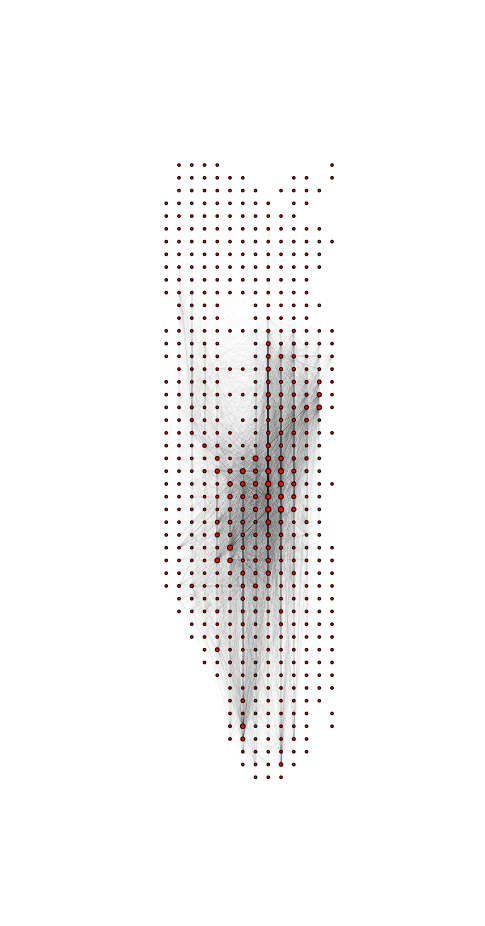

In [11]:
#Open the pickle file with the adjacency matrix inside
fileName = open('rushhr_adjacencymatrix.p')
A = pickle.load(fileName)
fileName.close()
plotGraph(A)

In [14]:
#Create a test graph - if don't load in data
if False:
    A = nx.Graph()
    for i in range(3):
        for j in range(3):
            A.add_node((i,j), pos=(i,j))
    #Add some edges
    A.add_edge((0,0),(1,0),weight=5)
    A.add_edge((0,0),(1,0),weight=2)
    A.add_edge((0,0),(1,2),weight=4)
    A.add_edge((0,0),(2,2),weight=4)
    A.add_edge((1,0),(0,2),weight=5)
    A.add_edge((1,0),(2,1),weight=2)
    A.add_edge((2,0),(0,1),weight=3)
    A.add_edge((2,0),(2,1),weight=1)
    A.add_edge((1,1),(2,1),weight=3)
    A.add_edge((1,1),(2,2),weight=6)
    A.add_edge((2,1),(2,2),weight=2)
    A.add_edge((0,2),(1,2),weight=3)

    #Plot the graph
    G = A
    pos=nx.get_node_attributes(G,'pos')
    edges = G.edges()
    weights = [G[u][v]['weight']*2 for u,v in edges] #divide by 4 for scale in graphing
    nx.draw(G, pos, edges=edges, width=weights, node_size=10)
    nx.draw_networkx_labels(G,pos)
    plt.show()

In [15]:
#Step function for use in the next section
def step(x):
    if x > 0: return x
    else: return 0

In [25]:
#Create a BiPartite Graph
#Delete the previous graph if it exists
if 'B' in locals():
    del B
B = nx.Graph()
#Add the nodes
B.add_nodes_from(A.nodes(data=True),bipartite=0)
#B.nodes(data=True)
#Add the nodes (that are actually edges)
for edge in A.edges(data=True):
    #Extract the points
    P0 = edge[0]
    P1 = edge[1]
    #Find the distance between the points in each direction
    D = [abs(P0[0]-P1[0]), abs(P0[1]-P1[1])]
    #Find the L1 between the two points (manhattan distance)
    L1 = sum(D)
    #If the distance between the two points is only 1, no node should be added
    if L1 > 1:
        #Create a list of the divisiors
        divisors = [a+1 - step(a-D[0]) - step(a-D[1]) for a in range(L1+1)]
        #Add a second type of node for the connection
        B.add_node((P0,P1),bipartite=1)
        #Add edges for the type 0 nodes
        for i in range(min(P0[0],P1[0]),max(P0[0],P1[0])+1):
            for j in range(min(P0[1],P1[1]),max(P0[1],P1[1])+1):
                #Connections to the endpoints should noe be added
                if (i,j)!=P0 and (i,j)!=P1:
                    #Otherwise add conneciton with the appropriate weight
                    B.add_edge((P0,P1),(i,j),weight=float(edge[2]['weight'])/divisors[abs(P0[0]-i)+abs(P0[1]-j)])
#print(B.edges(data=True))

In [26]:
#Display the bipartite graph visually
G=B
#Create sets of each node type in the graph
X = set(node[0] for node in G.nodes(data=True) if node[1]['bipartite']==0)
Y = set(node[0] for node in G.nodes(data=True) if node[1]['bipartite']==1)

#Create positions for each in the set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
yscale = float(len(X))/len(Y) #Scale for graphic purposes
pos.update( (n, (2, i*yscale)) for i, n in enumerate(Y) ) # put nodes from Y at x=2

edges = G.edges()
weights = [G[u][v]['weight']*2 for u,v in edges] #divide by 4 for scale in graphing
nx.draw(G, pos=pos, edges=edges, width=weights, node_size=5)
nx.draw_networkx_labels(G,pos=pos)
plt.show()

KeyError: 'bipartite'

In [22]:
#Display the bipartite graph as a data table
from pandas import DataFrame 
columnOrder = [node[0] for node in B.nodes(data=True) if node[1]['bipartite']==0]
rowOrder = [node[0] for node in B.nodes(data=True) if node[1]['bipartite']==1]
BA = bipartite.biadjacency_matrix(B,rowOrder)
BA = BA.todense()
BA = np.around(BA,1)
BA = DataFrame(BA,rowOrder,columnOrder)
print(BA)


                  (0, 1)  (1, 2)  (0, 0)  (2, 1)  (0, 2)  (2, 0)  (2, 2)  \
((0, 0), (2, 2))     2.0     2.0     0.0     2.0     1.3     1.3     0.0   
((1, 0), (0, 2))     2.5     2.5     2.5     0.0     0.0     0.0     0.0   
((0, 1), (2, 0))     0.0     0.0     1.5     1.5     0.0     0.0     0.0   
((2, 1), (1, 0))     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
((1, 1), (2, 2))     0.0     3.0     0.0     3.0     0.0     0.0     0.0   
((1, 2), (0, 0))     2.0     0.0     0.0     0.0     2.0     0.0     0.0   

                  (1, 0)  (1, 1)  
((0, 0), (2, 2))     2.0     1.3  
((1, 0), (0, 2))     0.0     2.5  
((0, 1), (2, 0))     1.5     1.5  
((2, 1), (1, 0))     0.0     1.0  
((1, 1), (2, 2))     0.0     0.0  
((1, 2), (0, 0))     2.0     2.0  


In [23]:
#Find how many edges pass through each node
locations = [node[0] for node in B.nodes(data=True) if node[1]['bipartite']==0]
bipartite.degree_centrality(B,locations)
_,kthrough = bipartite.degrees(B,locations,weight='weight')
#print(kthrough)
#Find how many edges end on each node
kend = A.degree(weight='weight')
#print(kend)
#Normalize each of entities and add together
locations = [node[0] for node in B.nodes(data=True) if node[1]['bipartite']==0]
print(locations)
#Calculate the normalized through
kthrough = [kthrough[loc] for loc in locations]
m = max(kthrough)
kthrough = [float(v)/m for v in kthrough]
print('through:',kthrough)
#Calculate the normalized end
kend = [kend[loc] for loc in locations]
m = max(kend)
kend = [float(v)/m for v in kend]
print('end:',kend)
#Calculate the score
score = [round(b-a,4) for a,b in zip(kthrough,kend)]
print(score)

[(0, 1), (1, 2), (0, 0), (2, 1), (0, 2), (2, 0), (2, 2), (1, 0), (1, 1)]
('through:', [0.7800000000000001, 0.9000000000000001, 0.4800000000000001, 0.7800000000000001, 0.4, 0.28, 0.0, 0.6600000000000001, 1.0])
('end:', [0.25, 0.5833333333333334, 0.8333333333333334, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 1.0, 0.75, 0.75])
[-0.53, -0.3167, 0.3533, -0.1133, 0.2667, 0.0533, 1.0, 0.09, -0.25]
